# Display results from scaffold analyses performed in the notebook 05

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 50)
import pickle
from rdkit.Chem import PandasTools
from IPython.display import display, HTML
from rdkit import Chem
from joblib import Parallel, delayed
from rdkit.Chem import Draw

import logging 
logging.basicConfig(level=logging.INFO, format ='%(levelname)s - %(message)s')

import cpmolgan.utils as utils
import cpmolgan.nearest_neighbors as nn



In [2]:
args = {
    'figures_dir':'figures',
    'filename_common_scafolds_table':'results/scafold_analysis/common_MurkoScafold_quantification_Gene_vs_Excape_mean.csv',
    'filename_large_consitent_scafolds':'results/scafold_analysis/LargeConsistentlyEnrichedScafolds.pkl',    
    'filename_Excape_agonist_with_enriched_scaf':'results/scafold_analysis/Excape_agonists_with_LargeConsistentlyEnrichedScafolds.csv',
    'Excape_genes':["TP53","BRCA1","NFKB1","HSPA5", "CREBBP", "STAT1", "STAT3","HIF1A", "NFKBIA","JUN","PRKAA1","PDPK1"],
                    #   0      1      2        3        4         5        6       7        8       9      10      11 
}


# 1. Common Scaffolds with Excape 
- Quantification (for each gene) of its commom scafolds with its correcponding Excape agonists
- Paper **Supplementary Table 1**

In [3]:
murkos = pd.read_csv( args['filename_common_scafolds_table'], index_col=0)
display_cols = ['Gene_Symbol_Excape','Gene_Symbol_generated','N_scaf_generated_mean','N_common_scaf_mean']
murkos[display_cols]

,Gene_Symbol_Excape,Gene_Symbol_generated,N_scaf_generated_mean,N_common_scaf_mean
0,BRCA1,BRCA1,14265.333333,210.000000
1,CREBBP,CREBBP,17494.666667,0.333333
2,HIF1A,HIF1A,15538.333333,1.000000
3,HSPA5,HSPA5,16126.000000,47.000000
4,JUN,JUN,13577.333333,0.000000
5,NFKB1,NFKB1,12354.666667,33.000000
6,NFKBIA,NFKBIA,14982.666667,0.000000
7,PDPK1,PDPK1,14597.333333,0.666667
8,PRKAA1,PRKAA1,15086.666667,0.000000
9,STAT1,STAT1,16215.666667,13.666667


# 2. Enriched scafolds for a selected gene 
- Paper supplementary **Figure 5**

In [4]:
large_consistent_scaf = pickle.load(open(args['filename_large_consitent_scafolds'], "rb"))

TP53 Large significantly enriched scafolds: 3


,signif_scafolds,signif_mols
0,O=C(Nc1cccc2ccccc12)c1ccccc1,
1,O=C(Nc1ccccc1)c1cccc2ccccc12,
2,c1ccc(-c2cccc3ccccc23)cc1,

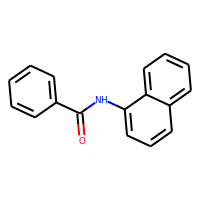
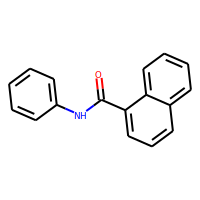
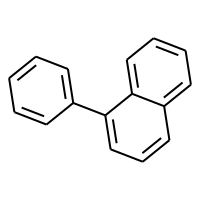

In [5]:
# Pick a gene
plot_gene = args['Excape_genes'][0]

# Display molcules
plot_df = pd.DataFrame()
plot_df['signif_scafolds'] = large_consistent_scaf[plot_gene]
print("%s Large significantly enriched scafolds: %i"%(plot_gene, len(plot_df)))
PandasTools.AddMoleculeColumnToFrame(plot_df, smilesCol='signif_scafolds' , molCol='signif_mols' ,includeFingerprints=False)
display(HTML(plot_df.to_html(escape=False)))

## 3. Excape agonists containing significantly enriched scafolds for a selected gene
- Collect and Save scafolds for all genes 
- These ExCAPE agonist are presented in **Figure 4a** and **Supplementary Figure 6**

In [6]:
Excape_enriched_scafs = pd.read_csv(args['filename_Excape_agonist_with_enriched_scaf'],index_col=0)

,Gene_Symbol,Excape_hit_name,murcko,mol_Excape,murcko_scafold,SMILES_standard_Excape
0,BRCA1,BRCA1_#1,,,O=C(NCCc1ccccc1)Nc1ccc2c(c1)OCO2,O=C(NCCc1ccccc1)Nc1ccc2c(c1)OCO2
1,NFKB1,NFKB1_#1,,,O=C(C=Cc1ccccc1)Nc1ccccc1,COc1ccc(NC(=O)C=Cc2ccc(Cl)cc2)cc1
2,NFKB1,NFKB1_#2,,,O=C(C=Cc1ccccc1)c1ccccc1,COc1cc(C=C(C#N)C(=O)c2ccc(O)c(O)c2)cc(I)c1O

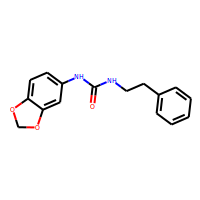
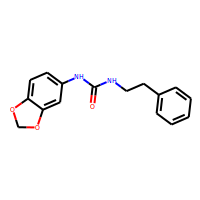
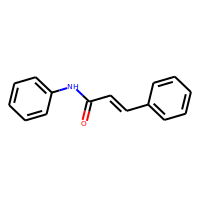
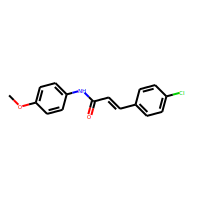
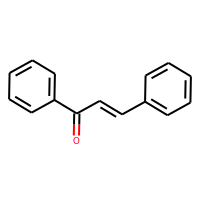
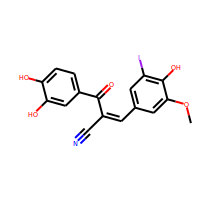

In [7]:
# Show compounds for all ExCAPE genes
plot_genes = args['Excape_genes']
Excape_enriched_scafs = Excape_enriched_scafs.loc[ Excape_enriched_scafs.Gene_Symbol.isin(plot_genes)]
PandasTools.AddMoleculeColumnToFrame(Excape_enriched_scafs, smilesCol='murcko_scafold' , molCol='murcko' ,includeFingerprints=False)
PandasTools.AddMoleculeColumnToFrame(Excape_enriched_scafs, smilesCol='SMILES_standard_Excape' , molCol='mol_Excape' ,includeFingerprints=False)
display(HTML(Excape_enriched_scafs[['Gene_Symbol','Excape_hit_name','murcko','mol_Excape','murcko_scafold','SMILES_standard_Excape']].to_html(escape=False)))

## 4. Generated molecules containing a given large-consistent-scafold and with high simmilairty to the corresponding agonist
- Some of these generated molecules are presented in **Figure 4b**

NFKB1_#1 O=C(C=Cc1ccccc1)Nc1ccccc1


,GeneSymbol,Murkco,Excape,Generated,sim2Excape,counts
0,NFKB1,,,,0.847826,1
1,NFKB1,,,,0.804348,4
2,NFKB1,,,,0.804124,1
3,NFKB1,,,,0.791667,1
4,NFKB1,,,,0.775510,1
5,NFKB1,,,,0.772277,1
6,NFKB1,,,,0.764706,1
7,NFKB1,,,,0.747475,1
8,NFKB1,,,,0.687500,1
9,NFKB1,,,,0.686869,1

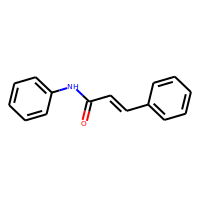
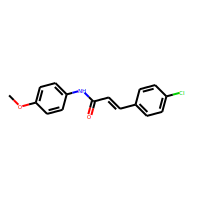
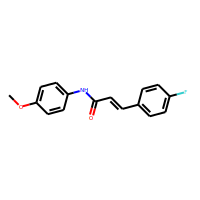
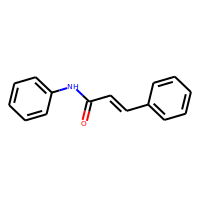
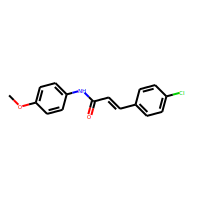
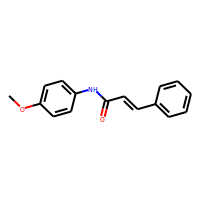
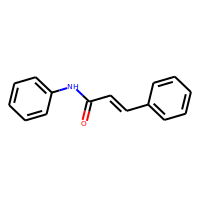
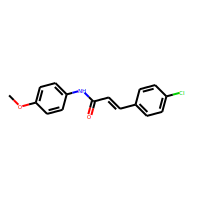
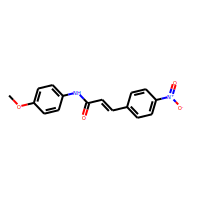
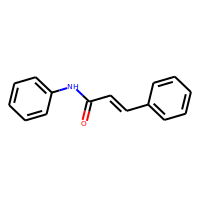
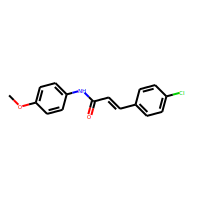
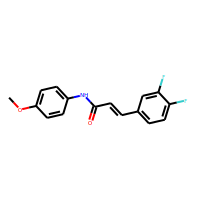
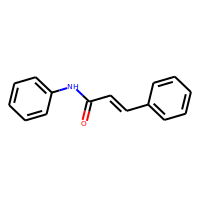
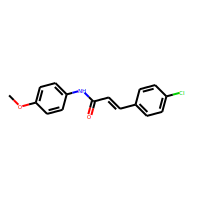
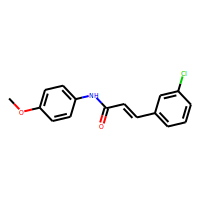
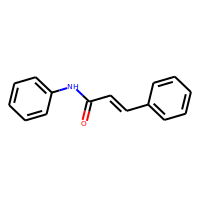
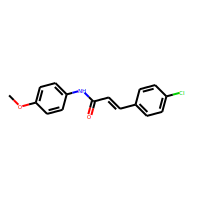
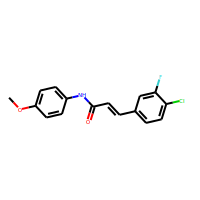
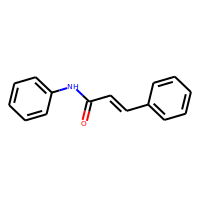
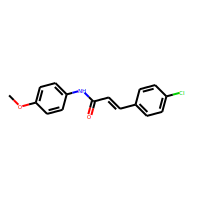
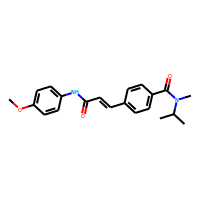
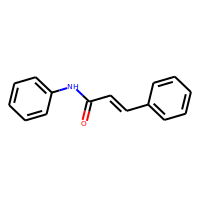
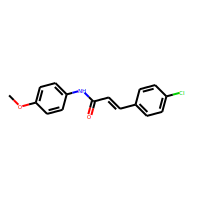
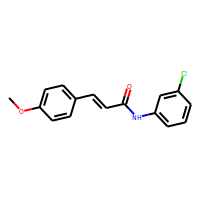
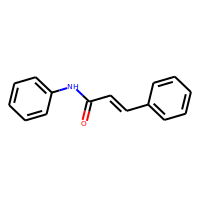
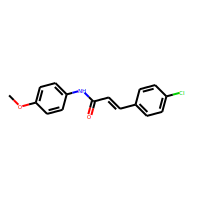
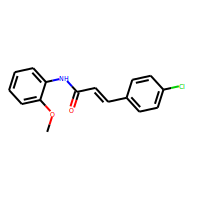
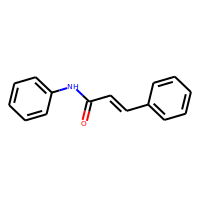
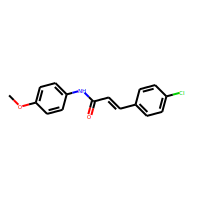
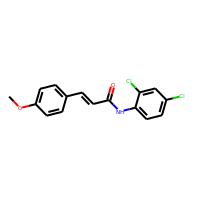
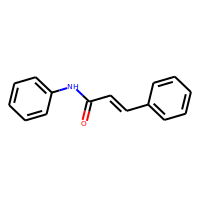
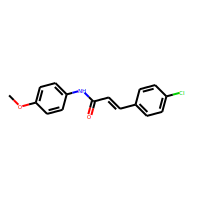
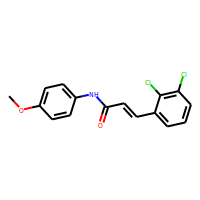
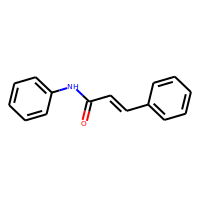
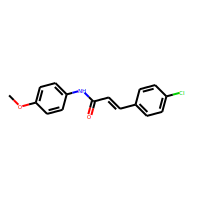
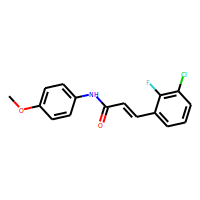
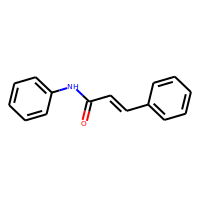
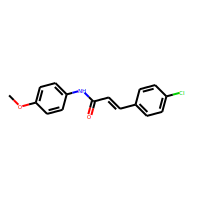
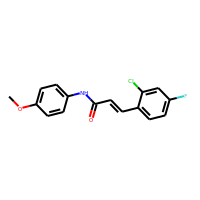
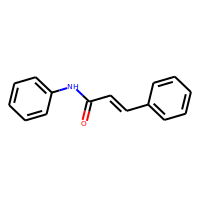
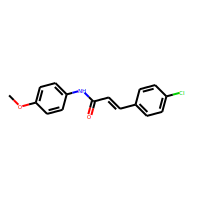
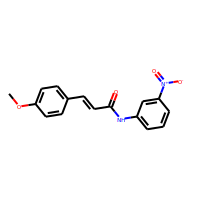
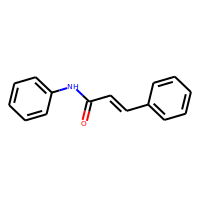
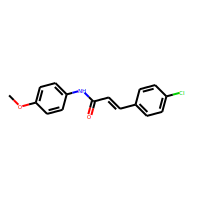
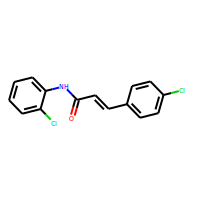
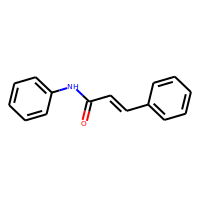
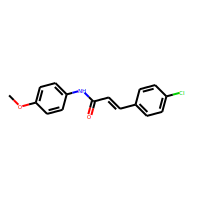
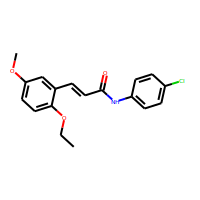
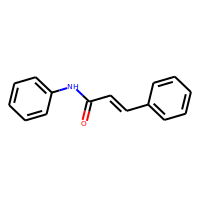
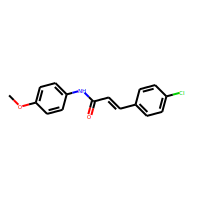
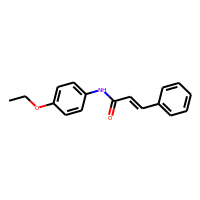
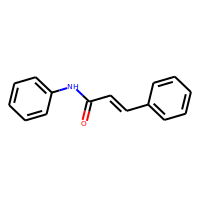
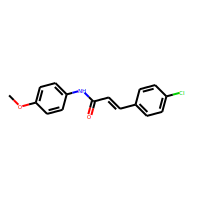
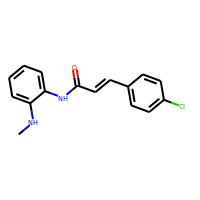
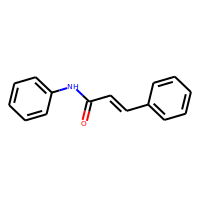
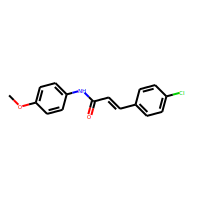
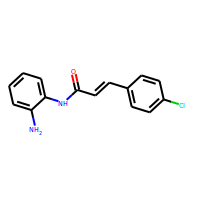
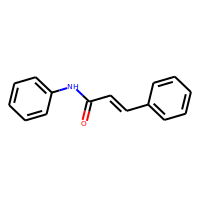
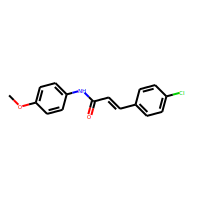
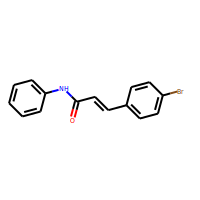
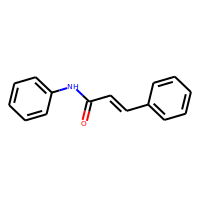
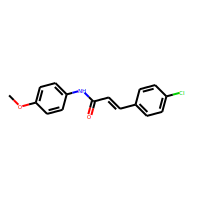
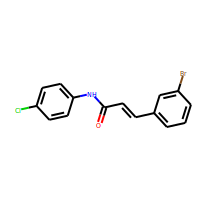
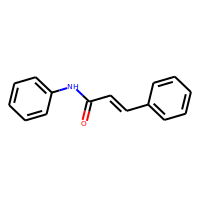
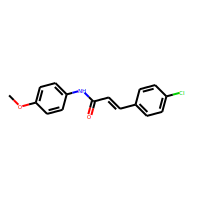
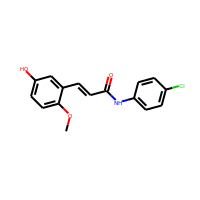
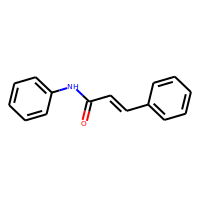
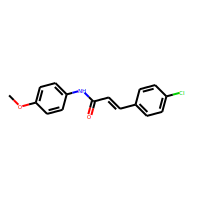
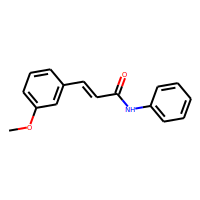
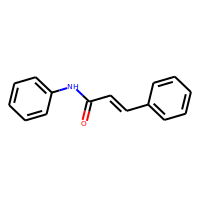
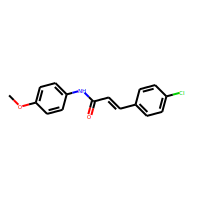
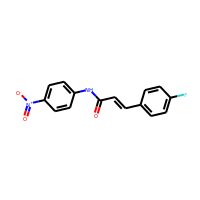

In [8]:
# Pick a gene and correponding scafold using the index from the DataFrame above
idx = 1
plot_gene, plot_scafold, excape_hit_name = Excape_enriched_scafs.loc[ idx , ['Gene_Symbol','murcko_scafold','Excape_hit_name']]
print(excape_hit_name, plot_scafold)

# Read and dispkay generated moleules with enriched scafold and highly simmilar to the ExCAPE hit
ref_filename = 'results/scafold_analysis/GeneratedMols_with_LargeConsistentlyEnrichedScafolds_and_HighExcapeSim__GENE.csv'
high_sim_cpds = pd.read_csv(ref_filename.replace('GENE',plot_gene),index_col=0)
high_sim_cpds = high_sim_cpds.query('(GeneSymbol==@plot_gene)&(Murcko==@plot_scafold)')
PandasTools.AddMoleculeColumnToFrame(high_sim_cpds, smilesCol='SMILES_standard' , molCol='Generated' ,includeFingerprints=False)
PandasTools.AddMoleculeColumnToFrame(high_sim_cpds, smilesCol='Excape_SMILES_standard' , molCol='Excape' ,includeFingerprints=False)
PandasTools.AddMoleculeColumnToFrame(high_sim_cpds, smilesCol='Murcko' , molCol='Murkco' ,includeFingerprints=False)
display(HTML(high_sim_cpds[['GeneSymbol','Murkco','Excape','Generated','sim2Excape','counts']].to_html(escape=False)))

# Save molecules to svg
if len(high_sim_cpds)>0:
    filename = os.path.join(args['figures_dir'],'Similar_genereated_ExCAPE_hit_'+excape_hit_name+'.svg')
    mols = [ Chem.MolFromSmiles(i) for i in high_sim_cpds['SMILES_standard'].values ] 
    grid = Draw.MolsToGridImage(mols, molsPerRow=len(mols), subImgSize=(500, 250), useSVG=True)
    with open(filename, 'w') as f:
        f.write(grid)